# Describe the goals of the study

Testing changes related to the introduction of an improved recommendation system of an international online store.
The changes that will be tested are: better conversion into product page views, instances of adding items to the shopping cart, and purchases. 
At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase. 

## Technical description¶
- Test name: recommender_system_test
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-23
- End date: 2020-12-30
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product - page views (the product_page event), product card views (product_card) and purchases (purchase). - At each of the stage of the funnel product_page → product_card → purchase, there will be at least a 10% increase.
- Expected number of test participants: 6000

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
from scipy import stats
import math
import matplotlib.dates as mdates
import datetime 
import math
import plotly.express as px

## Download the data

### The calendar of marketing events for 2020

In [6]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [7]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


In [8]:
marketing_events['start_dt'].describe()

count             14
unique            14
top       2020-06-25
freq               1
Name: start_dt, dtype: object

This data contains 14 rows: 
- name of the marketing event
- regions where the ad campaign will be held
- campaign start date
- campaign end date

The data includes events before and after the test: 7-21/12

### All users who signed up in the online store from

In [9]:
new_users = pd.read_csv('/datasets/final_ab_new_users_us.csv')
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [10]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


This data contains 61733  rows:
- user_id
- sign-up date
- region 
- device used to sign up

 ###  All events of the new users within the period from December 7, 2020 through January 1, 2021

In [11]:
ab_events= pd.read_csv('/datasets/final_ab_events_us.csv')
ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [12]:
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [13]:
ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

This data contains: 
- user_id
- event date and time
- event type name: purchase, product_cart, product_page, login
- additional data on the event (for instance, the order total in USD for purchase events)

###  Table containing test participants
15% of the new users from the EU region

In [14]:
ab_participants = pd.read_csv('/datasets/final_ab_participants_us.csv')
ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [15]:
ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


In [16]:
ab_participants['group'].unique()

array(['A', 'B'], dtype=object)

In [17]:
ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

This data contains: 
- user_id
- the test group the user belonged to: А (control), B (new payment funnel)
- test name : recommender_system_test, interface_eu_test

## Explore the data:

### converting data types

In [18]:
# convert dates to datetime objects
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y.%m.%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y.%m.%d')
new_users['first_date']= pd.to_datetime(new_users['first_date'], format='%Y.%m.%d')
ab_events['event_dt']= pd.to_datetime(ab_events['event_dt'], format='%Y.%m.%d %H:%M:%S')

### Missing Values

In [19]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [20]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [21]:
ab_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [22]:
ab_events[ab_events['details'].isnull()]

,user_id,event_dt,event_name,details
62740,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
62741,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
62742,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
62743,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
62744,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [23]:
#replace missing values in details column with 0
ab_events['details']= ab_events['details'].fillna(0.00)

In [24]:
ab_participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

### Duplicate values

In [25]:
#Check for duplicates
display(marketing_events[marketing_events.duplicated()].head())
display(new_users[new_users.duplicated()].head())
display(ab_events[ab_events.duplicated()].head())
display(ab_participants[ab_participants.duplicated()].head())

,name,regions,start_dt,finish_dt


,user_id,first_date,region,device


,user_id,event_dt,event_name,details


,user_id,group,ab_test


No duplicates in data

## Carry out exploratory data analysis

### Study conversion at different stages of the funnel

In [26]:
ab_participants.groupby(['group','ab_test']).size()

group  ab_test                
A      interface_eu_test          5831
       recommender_system_test    3824
B      interface_eu_test          5736
       recommender_system_test    2877
dtype: int64

In [27]:
#query only ab_test for interface_eu_test
interface_eu_test = ab_participants.query('ab_test == "interface_eu_test"' )
interface_eu_test.head()

,user_id,group,ab_test
6701,D4E530F6595A05A3,A,interface_eu_test
6702,773ECB64E45DEBAB,A,interface_eu_test
6703,6BCB0F33D3BAB8C2,A,interface_eu_test
6704,AABA4219186465C9,A,interface_eu_test
6705,2BA8FA8754D1FE50,B,interface_eu_test


In [28]:
interface_eu_test.groupby(['group']).size()

group
A    5831
B    5736
dtype: int64

In [29]:
#merge tables: new_users, ab_events, interface_eu_test
#df = new_users.merge(ab_events, on='user_id', how='left')
df = ab_events.merge(interface_eu_test, on='user_id', how='left')
df.head()

,user_id,event_dt,event_name,details,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,NaN,NaN


In [30]:
# drop users who don't belong to any test group
df = df.dropna()
df.head()

,user_id,event_dt,event_name,details,group,ab_test
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test
11,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A,interface_eu_test
12,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B,interface_eu_test
13,0313C457F07C339E,2020-12-07 13:10:48,purchase,9.99,A,interface_eu_test


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81927 entries, 3 to 440315
Data columns (total 6 columns):
user_id       81927 non-null object
event_dt      81927 non-null datetime64[ns]
event_name    81927 non-null object
details       81927 non-null float64
group         81927 non-null object
ab_test       81927 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 4.4+ MB


In [32]:
# period of time the data covers
df['event_dt'].describe()

count                   81927
unique                  52662
top       2020-12-20 02:51:18
freq                        7
first     2020-12-07 00:02:48
last      2020-12-30 18:28:55
Name: event_dt, dtype: object

The minimum date is: 2020-12-07 

The maximum date is : 2020-12-30

In [33]:
#check if some of the participants might have gotten into both tests- interface_eu_test & recommender_system_test
recommender_system_test = ab_participants.query('ab_test == "recommender_system_test"' )
both_groups = df[df['user_id'].isin(recommender_system_test['user_id'])]
len(both_groups)

5894

In [34]:
# participants only in one group
df = df[np.logical_not(df['user_id'].isin(both_groups['user_id']))]
len(df['user_id'])

76033

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76033 entries, 3 to 440315
Data columns (total 6 columns):
user_id       76033 non-null object
event_dt      76033 non-null datetime64[ns]
event_name    76033 non-null object
details       76033 non-null float64
group         76033 non-null object
ab_test       76033 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 4.1+ MB


In [36]:
#number of unique users
df['user_id'].nunique()

9963

In [37]:
# group by event name and count their frequency of occurrence
df.groupby(['event_name'])['event_name'].count().sort_values(ascending = False)

event_name
login           32456
product_page    21463
purchase        11237
product_cart    10877
Name: event_name, dtype: int64

The most frequent event is the login  with 32,456 events.
The product page has 21,463 evets.
The purchase screen has 11,237 events.
The product_cart has 10,877 events.

In [38]:
#find the overall proportions of all users 
users= (df.groupby(['event_name'])['user_id'].nunique().sort_values(ascending = False) / df.user_id.nunique()).reset_index()

users.style.format({'user_id': '{:,.1%}'.format})

,event_name,user_id
0,login,100.0%
1,product_page,66.4%
2,purchase,34.5%
3,product_cart,33.3%


100% of all users did login, 66% of all users made the product_page Screen , 34.5% the purchase and 33.3 the product_cart.     

In [39]:
#Calculate the proportion of users who performed the action at least once
at_least_once = df.groupby(['user_id','event_name'])['event_dt'].count().reset_index()
at_least_once = at_least_once[at_least_once.event_dt>=2]
at_least_once = at_least_once.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False) / df.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False)
at_least_once.reset_index()

,event_name,user_id
0,login,0.924413
1,product_page,0.923867
2,purchase,0.918777
3,product_cart,0.919155


For the login screen- 92% out of useres who made login for the first time made it once again.
For the roduct page - out of 61% users who made it for the first time, 92% made it once again.
For the purchase - out of 34.5% users who made it for the first time, 92% made it once again.
For the product cart - out of 33.3% users who made it for the first time, 92% made it once again.

The proportion of users who performed the action at least once is simialr for all events.

In [40]:
funnel_by_groups = []
for i in df.group.unique():
    group = df[df.group==i].groupby(['event_name', 'group'])['user_id'].nunique().reset_index() \
    .sort_values(by='user_id', ascending=False)
    display(group)
    funnel_by_groups.append(group)

,event_name,group,user_id
0,login,B,4952
2,product_page,B,3254
1,product_cart,B,1686
3,purchase,B,1653


,event_name,group,user_id
0,login,A,5010
2,product_page,A,3366
3,purchase,A,1782
1,product_cart,A,1629


In [41]:
#concatenate the data
funnel_by_groups = pd.concat(funnel_by_groups)
funnel_by_groups 

,event_name,group,user_id
0,login,B,4952
2,product_page,B,3254
1,product_cart,B,1686
3,purchase,B,1653
0,login,A,5010
2,product_page,A,3366
3,purchase,A,1782
1,product_cart,A,1629


In [ ]:
#plot the funnel
fig = px.funnel(funnel_by_groups,x='user_id', y='event_name', color='group', title= 'Users Funnel')
fig.show()

In [43]:
#extract users id that made an action
funnel_shift = df.groupby(['event_name'])['user_id'].nunique().reset_index().sort_values(by= 'user_id', ascending = False)

#calculate the prcentage change from one funnel to another
funnel_shift['percentage_change'] = funnel_shift['user_id'].pct_change()
funnel_shift

,event_name,user_id,percentage_change
0,login,9962,NaN
2,product_page,6620,-0.335475
3,purchase,3435,-0.481118
1,product_cart,3315,-0.034934


From the funnel, the order in which the actions took place is:
login - product page - product_cart - purchase

Not all of the actions are part of a single sequence: for example,  it might be possible to make a purchase without going throgh the product cart screen for group A. 

It can also be seen that the stage we lose most of the users is the from the product page to the purchase screen (48% decrease in users who processed to purchase)

### Is the number of events per user distributed equally among the samples?


In [44]:
#number of unique users
df['user_id'].nunique()

9963

In [45]:
#number of events
df['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [46]:
#average number of events per user
df.groupby(['user_id'])['event_name'].count().reset_index().sort_values(by='event_name', ascending = False)['event_name'].mean()

7.6315366857372275

In [47]:
#event per user
event_per_user = df.groupby(['group', 'event_name']).size().reset_index()
event_per_user.columns = ['group', 'event_name', 'users']
event_per_user

,group,event_name,users
0,A,login,16354
1,A,product_cart,5402
2,A,product_page,10932
3,A,purchase,5844
4,B,login,16102
5,B,product_cart,5475
6,B,product_page,10531
7,B,purchase,5393


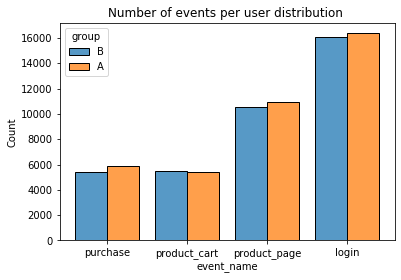

In [48]:
sns.histplot(df, x="event_name", hue='group', multiple="dodge", shrink=.8)
plt.title('Number of events per user distribution ')
plt.show() 

The number of events per user is mostly distributed equally between group A (control) and group B (new payment funnel).


### Are there users who are presented in both samples?


In [49]:
#check if some of the participants might have gotten into both group A and group B
groupA = df.query('group == "A"' )
groupB = df.query('group == "B"' )

both_groups = groupA[groupA['user_id'].isin(groupB['user_id'])]
both_groups

,user_id,event_dt,event_name,details,group,ab_test


No participants in both group A and group B

### How is the number of events distributed among days?


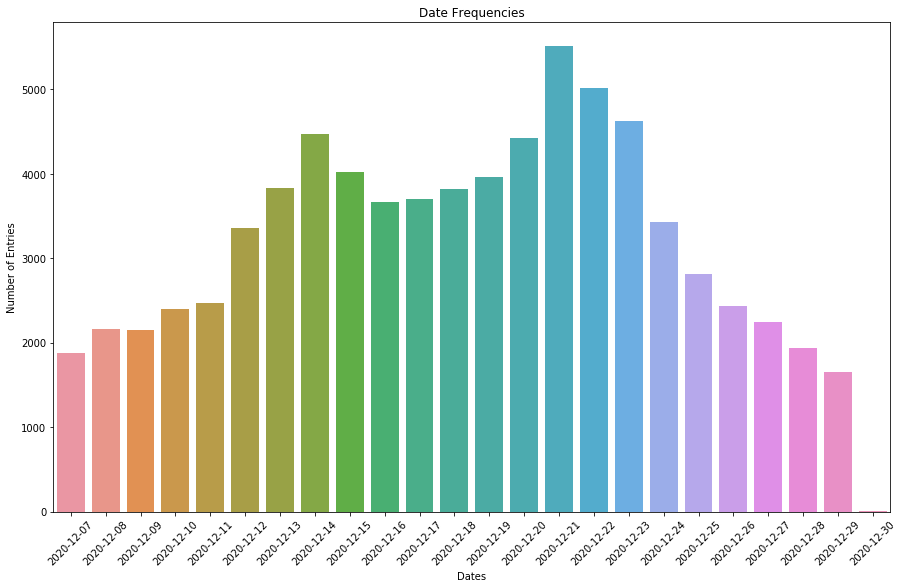

In [50]:
df['event_date'] = df['event_dt'].dt.date


# count the unique dates and their frequencies
events_by_date = df['event_date'].value_counts().rename_axis('event_date').reset_index(name='count').sort_values(by='event_date')

# plot bar graph
plt.figure(figsize=(15, 9))
ax = sns.barplot(data = events_by_date, x='event_date', y='count')

plt.title('Date Frequencies')
plt.xlabel('Dates')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.show()

In [51]:
#check for marketing events within the test dates
marketing_events[marketing_events['start_dt']>= pd.to_datetime('2020-12-07')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


From the number of events distributed among days figure it can be seen that there is a peek in the events count in the week before Christmas & New Year (which occured at the 25/12/2020).

## Evaluate the A/B test results:

In order to check if there is a statistically significant difference between groups A and B, we need to check the proportions - the share of users from all users in the test that had an event compared to the other test (conversions)

In [52]:
#calculate the number of users in each group
control = df[df.group=='A']['user_id'].unique()
test = df[df.group=='B']['user_id'].unique()

print("The number of users in group A is: ", len(control))
print("The number of users in group B is: ", len(test))

The number of users in group A is:  5011
The number of users in group B is:  4952


In [53]:
#calculate the number of users by event in each test group who preformed an action
pivot = df.pivot_table(index = 'event_name', values = 'user_id', columns='group', aggfunc=lambda x: x.nunique()).reset_index()
pivot

group,event_name,A,B
0,login,5010,4952
1,product_cart,1629,1686
2,product_page,3366,3254
3,purchase,1782,1653


The number of users in different groups is simialr for all events

In [54]:
# calculate share 
share = pivot
share['A_share'] = pivot['A'] / df[df.group=='A']['user_id'].nunique() 
share['B_share'] = pivot['B'] / df[df.group=='B']['user_id'].nunique()

share

group,event_name,A,B,A_share,B_share
0,login,5010,4952,0.999800,1.000000
1,product_cart,1629,1686,0.325085,0.340468
2,product_page,3366,3254,0.671722,0.657108
3,purchase,1782,1653,0.355618,0.333805


There is vaery small different in the share (1-2%) for all events between the groups, while the share of group A us higher for the purchase event.

In [55]:
#z-score test (proportion test) to check the statistical difference between the proportions
#compare the 2 groups for each event

group1 = 'A'
group2 = 'B'

for event in pivot.event_name.unique():

    #success for each group will be the value of action from pivot table
    successes1=pivot[pivot.event_name==event][group1].iloc[0]
    successes2=pivot[pivot.event_name==event][group2].iloc[0]
    
    #value of trials will be the number of users in the groups
    trials1=df[df.group=='A']['user_id'].nunique()
    trials2=df[df.group=='B']['user_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    alpha=0.05

    print('p-value: ', p_value)
    print('alpha level: ', alpha)

    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',group1,',' ,group2)
    else:
        print("Fail to Reject H0 for", event,'and groups',group1,',',group2) 

p-value:  0.3201520788748984
alpha level:  0.05
Fail to Reject H0 for login and groups A , B
p-value:  0.10323395997153062
alpha level:  0.05
Fail to Reject H0 for product_cart and groups A , B
p-value:  0.12244077100223438
alpha level:  0.05
Fail to Reject H0 for product_page and groups A , B
p-value:  0.021997971549269524
alpha level:  0.05
Reject H0 for purchase and groups A , B


We want to test the statistical significance of the difference in conversion between control- group A and new payment funnel- group B

The Null Hypothesis H0: There is no statistically significant difference in conversion between groups A & B. 
The Alternative Hypothesis H1: There is a statistically significant difference in conversion between  groups A & B.

For the events login, product page and product cart, the p_value is greater than the alpha level of 0.05 which means that we cannot reject the null hypothesis and we determine that there is no statistically significant difference  between groups A & B.

For the purchase event, the p_value is less than the alpha level of 0.05 which means that we can reject the null hypothesis and we determine that there is  a statistically significant difference between groups A & B.

## Conclusions 

The goal of this study was to determine changes related to the introduction of an improved recommendation system of an international online store.  It was expected that with this improved recommendation system, users will show a 10% increase in conversion.

From exploratory data analysis, it was found that the test started during holidays, which might have affected the users behavior in both groups due to fuctors such as sales and increased demand for gifts. 
In adittion we have data only till the 30/12/2020 - which means we didn't collect data of 14 days
for users who signed up at the 21/12/2020.

The number of events per user were distributed almost equally between groups A (control) and B (new payment funnel). Users who particpated in both groups where removed form the study.

From studing the sales funnel the order in which the actions took place is:
login - product page - product_cart - purchase.
The most frequent event after login is the product page 6620 events.
100% of all users did login, 66% of all users made the product_page Screen , 34.5% the purchase and 33.3 the product_cart.
The stage we lose most of the users is the from the product page to the purchase screen (48% decrease in users who processed to purchase). 


From the results of the A/B test, it can be concluded that there was no statistically significant difference between groups A and B for all events, except for the purchase event.
For this event, the conversation of group A was higher (35%) than group B (33%).


In cunclusion, it seems  that the improved recommendation system didn't increase the conversion sagnificantlly.  However it is suggested to do launche another test in differnet dats in order to be sure that holidays didn't have any effect on the test results. 
